In [1]:
import itertools as itr
import sys
import scipy
import cPickle
import time
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import math

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, validation_curve, RandomizedSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
# ATTRIBUTES TABLE:
# 1) electronegativity
# 2) ionic radius (Angstrom)
# 3) electronegativity
# 4) Period number
# 5) Group number
# 6) Atomic number
# 7) 1st ionization energy (eV)
PTP = {
       'H' :[2.20,0.012,2.20,1,1, 1, 13.5984],
       'Li':[0.98,0.76, 0.98,1,1, 3, 5.3917],
       'Be':[1.57,0.35, 1.57,2,2, 4, 9.3227],
       'B' :[2.04,0.23, 2.04,2,13,5, 8.298],
       'C' :[2.55,0.16, 2.55,2,14,6, 11.2603],
       'N' :[3.04,0.13, 3.04,2,15,7, 14.5341],
       'O' :[3.44,1.4,  3.44,2,16,8, 13.6181],
       'F' :[3.98,1.33, 3.98,2,17,9, 17.4228],
       'Na':[0.93,1.02, 0.93,3,1, 11,5.1391],
       'Mg':[1.31,0.72, 1.31,3,2, 12,7.6462],
       'Al':[1.61,0.535,1.61,3,13,13,5.9858],
       'Si':[1.90,0.4,  1.90,3,14,14,8.1517],
       'P' :[2.19,0.38, 2.19,3,15,15,10.4867],
       'S' :[2.58,0.37, 2.58,3,16,16,10.36],
       'Cl':[3.16,1.81, 3.16,3,17,17,12.9676],
       'K' :[0.82,1.38, 0.82,4,1, 19,4.3407],
       'Ca':[1.00,0.99, 1.00,4,2, 20,6.1132],
       'Sc':[1.36,0.745,1.36,4,3, 21,6.5615],
       'Ti':[1.54,0.605,1.54,4,4, 22,6.8281],
       'V' :[1.63,0.59, 1.63,4,5, 23,6.7462],
       'Cr':[1.66,0.52, 1.66,4,6, 24,6.7665],
       'Mn':[1.55,0.46, 1.55,4,7, 25,7.434],
       'Fe':[1.83,0.645,1.83,4,8, 26,7.9024],
       'Co':[1.88,0.745,1.88,4,9, 27,7.881],
       'Ni':[1.91,0.69, 1.91,4,10,28,7.6398],
       'Cu':[1.90,0.73, 1.90,4,11,29,7.7264],
       'Zn':[1.65,0.74, 1.65,4,12,30,9.3942],
       'Ga':[1.81,0.62, 1.81,4,13,31,5.9993],
       'Ge':[2.01,0.53, 2.01,4,14,32,7.8994],
       'As':[2.18,0.58, 2.18,4,15,33,9.7886],
       'Se':[2.55,0.5,  2.55,4,16,34,9.7524],
       'Br':[2.96,1.96, 2.96,4,17,35,11.8138],
       'Rb':[0.82,1.52, 0.82,5,1, 37,4.1771],
       'Sr':[0.95,1.12, 0.95,5,2, 38,5.6949],
       'Y' :[1.22,0.9,  1.22,5,3, 39,6.2173],
       'Zr':[1.33,0.72, 1.33,5,4, 40,6.6339],
       'Nb':[1.6, 0.69, 1.6, 5,5, 41,6.7589],
       'Mo':[2.16,0.65, 2.16,5,6, 42,7.0924],
       'Tc':[1.9, 0.56, 1.9, 5,7, 43,7.28],
       'Ru':[2.2, 0.68, 2.2, 5,8, 44,7.3605],
       'Rh':[2.28,0.68, 2.28,5,9, 45,7.4589],
       'Pd':[2.20,0.86, 2.20,5,10,46,8.3369],
       'Ag':[1.93,1.26, 1.93,5,11,47,7.5762],
       'Cd':[1.69,0.97, 1.69,5,12,48,8.9938],
       'In':[1.78,0.8,  1.78,5,13,49,5.7864],
       'Sn':[1.96,0.69, 1.96,5,14,50,7.3439],
       'Sb':[2.05,0.76, 2.05,5,15,51,8.6084],
       'Te':[2.1, 0.97, 2.1, 5,16,52,9.0096],
       'I' :[2.66,2.2,  2.66,5,17,53,10.4513],
       'Cs':[0.79,1.67, 0.79,6,1, 55,3.8939],
       'Ba':[0.89,1.35, 0.89,6,2, 56,5.2117],
       'La':[1.10,1.061,1.10,6,3, 57,5.5769],
       'Hf':[1.3, 0.71, 1.3, 6,4, 72,6.8251],
       'Ta':[1.5, 0.64, 1.5, 6,5, 73,7.5496],
       'W' :[2.36,0.62, 2.36,6,6, 74,7.864],
       'Re':[1.9, 0.56, 1.9, 6,7, 75,7.8335],
       'Os':[2.2, 0.63, 2.2, 6,8, 76,8.4382],
       'Ir':[2.2, 0.625,2.2, 6,9, 77,8.967],
       'Pt':[2.28,0.625,2.28,6,10,78,8.9587],
       'Au':[2.54,0.85, 2.54,6,11,79,9.2255],
       'Hg':[2.00,1.02, 2.00,6,12,80,10.4375],
       'Tl':[1.62,1.5,  1.62,6,13,81,6.1082],
       'Pb':[2.33,1.19, 2.33,6,14,82,7.4167],
       'Bi':[2.02,1.03, 2.02,6,15,83,7.2856],
       'Po':[2.0, 2.3,  2.0, 6,16,84,8.417],
       'At':[2.2, 0.62, 2.2, 6,17,85,9.3],
       'Fr':[0.7, 1.8,  0.7, 7,1, 87,4.0727],
       'Ra':[0.89,1.43, 0.89,7,2, 88,5.2784],
       'Ac':[1.1, 1.119,1.1, 7,3, 89,5.17],
       }

In [3]:
# Read the input file
with open('dp_dist_from_hull_data_expanded.csv', 'r') as data:
    dp_names = []
    energies = []
    ehull    = []
    for line in data:
        p = line.split()
        dp_names.append(p[0])
        energies.append(float(p[1])) # CONSIDERING eV/atom 
        ehull.append(float(p[2])) # CONSIDERING eV/atom 

In [4]:
# Prepare the feature matrix
vec = []
rows = 0
for names in dp_names:
    item0 = re.findall('[A-Z][^A-Z]*', names)[0]
    item1 = re.findall('[A-Z][^A-Z]*', names)[1]
    item2 = re.findall('[A-Z][^A-Z]*', names)[2]
    item3 = re.findall('[A-Z][^A-Z]*', names)[3]
    first_elem = ''.join([a for a in item0 if not a.isdigit()])
    first_elem = first_elem.split('.')[0]
    second_elem = ''.join([a for a in item1 if not a.isdigit()])
    second_elem = second_elem.split('.')[0]
    third_elem = ''.join([a for a in item2 if not a.isdigit()])
    third_elem = third_elem.split('.')[0]
    fourth_elem = ''.join([a for a in item3 if not a.isdigit()])
    fourth_elem = fourth_elem.split('.')[0] 
    # NOTE: position B' and B'' are symmetric. So, every feature regarding these 
    #       two atoms is going to be symmetrized: 
    #       |f_B' + f_B''|, |f_B' - f_B''| instead of the feature.
    # appending electronegativities 
    f1 = np.abs(PTP[second_elem][0] + PTP[third_elem][0])
    f2 = np.abs(PTP[second_elem][0] - PTP[third_elem][0])
    vec.extend([f1, f2, PTP[first_elem][0], PTP[fourth_elem][0]])
    # appending electron affinities, and ionization energy for A
    f1 = np.abs(PTP[second_elem][2] + PTP[third_elem][2])
    f2 = np.abs(PTP[second_elem][2] - PTP[third_elem][2])
    vec.extend([f1, f2, PTP[first_elem][6], PTP[fourth_elem][6]])
    # appendign atomic numbers
    f1 = np.abs(PTP[second_elem][5] + PTP[third_elem][5])
    f2 = np.abs(PTP[second_elem][5] - PTP[third_elem][5])
    vec.extend([f1, f2, PTP[first_elem][5], PTP[fourth_elem][5]])
    # appending group numbers (not for elemA, since it's always 2)
    f1 = np.abs(PTP[second_elem][4] + PTP[third_elem][4])
    f2 = np.abs(PTP[second_elem][4] - PTP[third_elem][4])
    vec.extend([f1, f2, PTP[first_elem][4], PTP[fourth_elem][4]])
    # appending period numbers
    f1 = np.abs(PTP[second_elem][3] + PTP[third_elem][3])
    f2 = np.abs(PTP[second_elem][3] - PTP[third_elem][3])
    vec.extend([f1, f2, PTP[first_elem][3], PTP[fourth_elem][3]])
    #appending ionic radii
    f1 = np.abs(PTP[second_elem][1] + PTP[third_elem][1])
    f2 = np.abs(PTP[second_elem][1] - PTP[third_elem][1])
    vec.extend([f1, f2, PTP[first_elem][1], PTP[fourth_elem][1]])
    # appending tolerance factor: (rA+rC)/(sqrt(2)*(rB+rC))
    mean = (PTP[second_elem][1] + PTP[third_elem][1])/2
    value = (PTP[first_elem][1] + PTP[fourth_elem][1])/(math.sqrt(2)*(mean + PTP[fourth_elem][1]))
    vec.append(value)
    # appending octahedral factor: rB/rO
    mean = (PTP[second_elem][1] + PTP[third_elem][1])/2
    value = (mean/PTP[fourth_elem][1])
    vec.append(value)
    # appending formation energies
    vec.append(energies[dp_names.index(names)])
    # appending distances from hull ---> this will be our target
    vec.append(ehull[dp_names.index(names)])
    # appending name (to be dropped immediately, but useful later)
    #vec.append(names)
    # -------------------
    rows = rows+1

data_matrix = np.reshape(vec,(rows,28))

In [5]:
# Convert the data matrix in a DataFrame object, for scikit_learn
d = {'EN_sum_B': data_matrix[:,0],  'EN_diff_B': data_matrix[:,1],  'EN_A': data_matrix[:,2],  'EN_C': data_matrix[:,3],
     'EA_sum_B': data_matrix[:,4],  'EA_diff_B': data_matrix[:,5],  'IE_A': data_matrix[:,6], 'IE_C': data_matrix[:,7],
     'AtomicNum_sum_B': data_matrix[:,8],  'AtomicNum_diff_B': data_matrix[:,9],  'AtomicNumA': data_matrix[:,10], 'AtomicNumC': data_matrix[:,11],  
     'Group_sum_B': data_matrix[:,12],  'Group_diff_B': data_matrix[:,13], 'Group_A': data_matrix[:,14], 'Group_C': data_matrix[:,15], 
     'Period_sum_B': data_matrix[:,16], 'Period_diff_B': data_matrix[:,17], 'Period_A': data_matrix[:,18], 'Period_C': data_matrix[:,19],
     'r_sum_B': data_matrix[:,20], 'r_diff_B': data_matrix[:,21], 'r_A': data_matrix[:,22], 'r_C': data_matrix[:,23], 
     'TF': data_matrix[:,24], 'OF': data_matrix[:,25], 'form_en': data_matrix[:,26], 'ehull': data_matrix[:,27]}
dp_data = pd.DataFrame(data = d)

In [6]:
# shuffle the ordering of the input vector, since it's in chunks of B1s
# for example: you have Ir-(all the B2s) THEN Ti-(all the B2s), ecc...
dp_data = dp_data.sample(frac=1).reset_index(drop=True)

In [7]:
# shuffle the ordering of the input vector, since it's in chunks of B1s
# for example: you have Ir-(all the B2s) THEN Ti-(all the B2s), ecc...
dp_data = dp_data.sample(frac=1).reset_index(drop=True)

/home/viscio/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/home/viscio/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


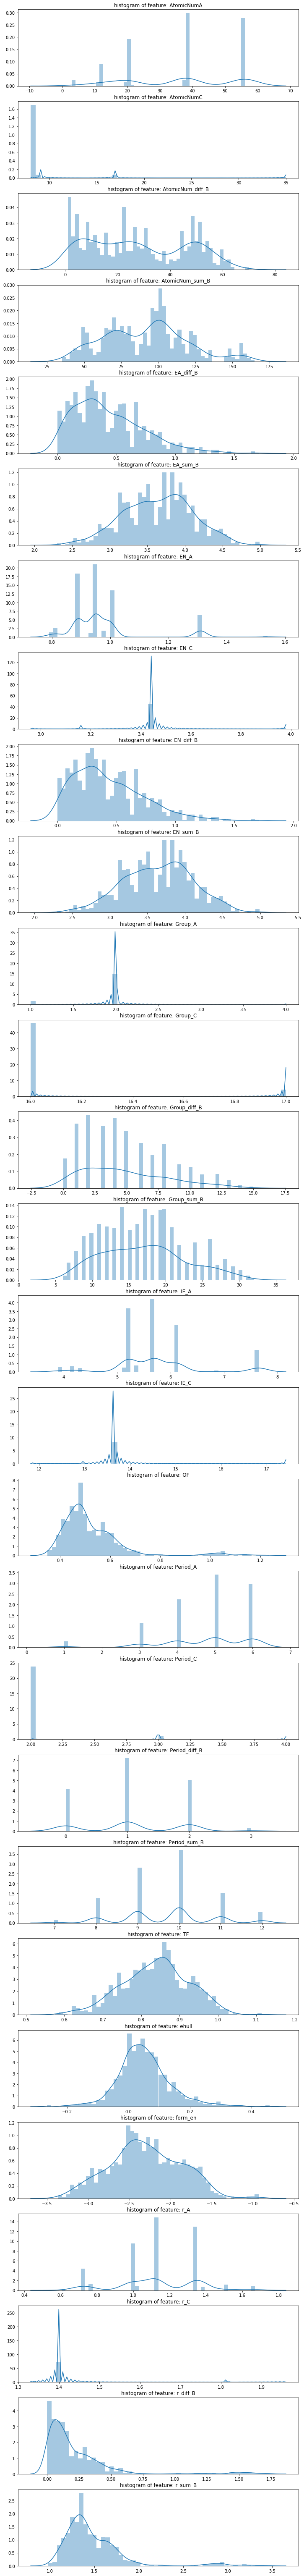

In [8]:
# Inspect the features
features = dp_data.ix[:,:].columns
num_features = len(features)
plt.figure(figsize=(12,num_features*4))
gs = gridspec.GridSpec(num_features, 1)
for i, cn in enumerate(dp_data[features]):
    ax = plt.subplot(gs[i])
    sns.distplot(dp_data[cn], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

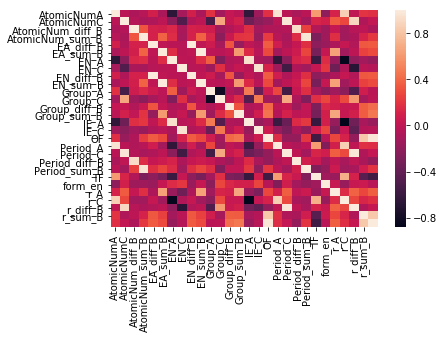

In [9]:
# lets plot a heat map to show correlation
feature_list = list(dp_data.drop(['ehull'],1).columns)
corr = dp_data.corr()
ax = sns.heatmap (corr, xticklabels = feature_list, yticklabels = feature_list)
plt.setp( ax.xaxis.get_majorticklabels(), rotation =  90)
plt.setp( ax.yaxis.get_majorticklabels(), rotation = 0)
plt.show()

In [10]:
# Atomic number features are really not relevant at all... 
dp_data = dp_data.drop(columns = ['AtomicNumA', 'AtomicNumC', 'AtomicNum_diff_B', 'AtomicNum_sum_B'])

In [11]:
# Define features and target
X = np.array(dp_data.drop(['ehull'],1)) 
y = np.array(dp_data['ehull'])

In [12]:
# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10 ,random_state = 42)

In [13]:
# K-Fold grid search for parameters optimization, as suggested in scikit-learn manual

# when we train on a certain fold, we use a second cross-validation split in order to choose hyperparameters
cv = KFold(n_splits = 10, shuffle = True)

# Chosen model (Random Forest) and hyperparameters to choose
rfr = RandomForestRegressor(random_state = 42)

# Define a standard scaler
std_scaler = StandardScaler()

In [14]:
# Now, we do a Grid Search
params = [{'randomforestregressor__n_estimators': [50, 100, 150, 200],
           'randomforestregressor__min_samples_split': [2, 5],
           'randomforestregressor__max_depth': [5,7,9,11,13],
           'randomforestregressor__min_samples_leaf': [2, 4], 
         }]

# find the model with the best generalization error
pipe = make_pipeline(std_scaler,
                        rfr)

# Perform the grid search proper
regressor = GridSearchCV(estimator = pipe, 
                         param_grid = params, 
                         cv = cv,  
                         n_jobs = -1, 
                         scoring = 'neg_mean_absolute_error',
                         iid = False)

# Fit the model
regressor.fit(X_train, y_train)
print('TRAIN Best Accuracy: %.2f%%' % (regressor.best_score_*100))
print('TRAIN Best Params:', regressor.best_params_)

TRAIN Best Accuracy: -3.12%
('TRAIN Best Params:', {'randomforestregressor__max_depth': 13, 'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 2})


In [15]:
# Predicted quantities for the best case scenario, either for the train and test situations
y_pred_train = regressor.predict(X_train)
y_pred_test  = regressor.predict(X_test)

# Some metrics:
# 1) mean absolute error (MAE)
print 'Train MAE:', mean_absolute_error(y_train, y_pred_train), 'eV/atom'
print 'Test  MAE:', mean_absolute_error(y_test, y_pred_test), 'eV/atom'
# 2) root mean squared error (RMSE)
print 'Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)), 'eV/atom'
print 'Test  RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)), 'eV/atom'
# 3) loss function ((y_true - y_true.mean()) ** 2).sum() as provided by .score method for KernelRidge Best possible value is 1
print 'Train score:', regressor.score(X_train, y_train)
print 'Test  score:', regressor.score(X_test, y_test)


Train MAE: 0.016451217512447554 eV/atom
Test  MAE: 0.03170728002052035 eV/atom
Train RMSE: 0.023907270244652227 eV/atom
Test  RMSE: 0.043489021193914755 eV/atom
Train score: -0.016451217512447554
Test  score: -0.03170728002052035


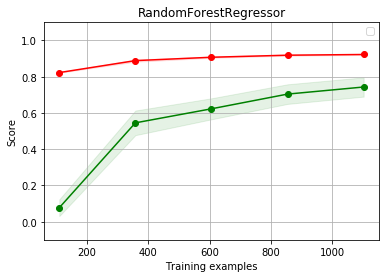

In [16]:
# Check for overfitting with learning curve
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(regressor.best_estimator_, X, y, train_sizes = np.linspace(.1, 1.0, 5), cv = 10)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("RandomForestRegressor")
plt.legend(loc="best")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
plt.ylim(-.1,1.1)
plt.show()


Variable: Period_C             Importance: 0.12
Variable: EN_diff_B            Importance: 0.11
Variable: Group_sum_B          Importance: 0.11
Variable: Period_A             Importance: 0.09
Variable: TF                   Importance: 0.08
Variable: EN_sum_B             Importance: 0.07
Variable: AtomicNumA           Importance: 0.05
Variable: EA_diff_B            Importance: 0.05
Variable: OF                   Importance: 0.05
Variable: AtomicNumC           Importance: 0.04
Variable: EN_C                 Importance: 0.04
Variable: Group_diff_B         Importance: 0.04
Variable: EA_sum_B             Importance: 0.03
Variable: Period_sum_B         Importance: 0.03
Variable: form_en              Importance: 0.03
Variable: IE_C                 Importance: 0.02
Variable: AtomicNum_diff_B     Importance: 0.01
Variable: AtomicNum_sum_B      Importance: 0.01
Variable: Group_A              Importance: 0.01
Variable: Group_C              Importance: 0.01
Variable: Period_diff_B        Importanc

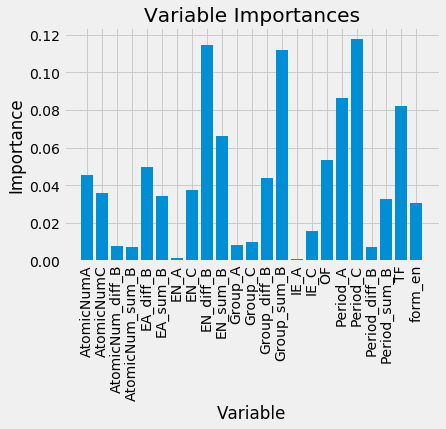

In [17]:
# Get numerical feature importances
importances = list(regressor.best_estimator_.steps[1][1].feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
for pair in feature_importances:
    print 'Variable: {:20} Importance: {}'.format(*pair)

# Feature importance graph
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.show()

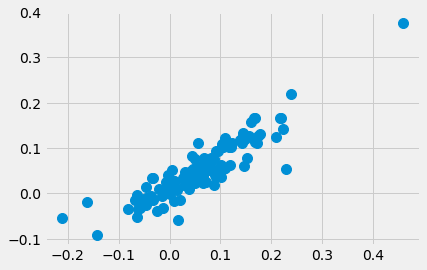

In [18]:
# Usual graph with differences between test data and predicted data
plt.style.use('fivethirtyeight')
plt.plot(y_test, y_pred_test, 'o', markersize=10)
plt.show()